# **Assignment 2:** Convolutional Autoencoder

#### **Course:** SCC0270-SCC5809 Artificial Neural Networks

#### **Professor:** Moacir Antonelli Ponti

#### **Assistant:** Ana Letícia Garcez Vicente


---
### **Personal Info:**
*   **Student:**
    *   Your Name: Matheus Victal Cerqueira
    *   Your USP Number: 10276661

In this assignment you will practice building a Convolutional Autoencoder on the Google Colab environment and with PyTorch. The goals of this practice are the following:

-   Develop familiarity with uploading a dataset.
-   Gain experience with building a model.
-   Train a Convolutional Autoencoder.
-   Use visualization tools to evaluate your result.
- Use the trained Autoencoder as a feature extractor

![image.png](attachment:image.png)

# 1. Dataset

MNIST is a dataset of handwritten digits (0 - 9) with 60.000 samples for training and 10.000 for testing.

http://yann.lecun.com/exdb/mnist/

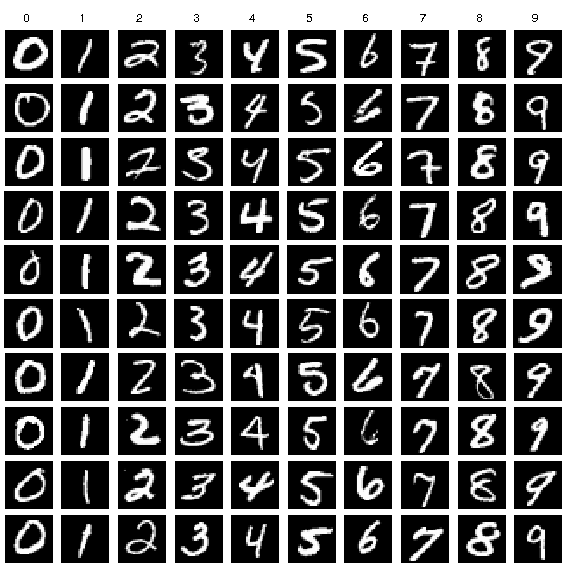

## Preparing Task: Download training and testing sets of MNIST using Pytorch framework

In [ ]:
import torch
from torchvision import datasets
from torchvision import transforms

batch_size = 128 # defining the batch_size

# Tensor transformation method to turn images from MNIST to tensors
tensor_transform = transforms.ToTensor()


# Setting the training dataset
train_dataset = datasets.MNIST(root='./mnist_data',
                               train=True,
                               download=True,
                               transform=tensor_transform)

# Setting the testing dataset
test_dataset = datasets.MNIST(root='./mnist_data',
                               train=False,
                               download=True,
                               transform=tensor_transform)

# Setting the training and testing datasets as pytorch dataloaders with batch
# size of 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

# 2. Denoising Convolutional Autoencoder

The concept of an Autoencoder is illustrated in the image above, comprising two fundamental components: the encoder and the decoder. The encoder takes the input, which in our case is a noisy image, and transforms it into a latent space representation. Subsequently, the decoder receives this encoded image and endeavors to reconstruct the original image, this time removing the noise from it.


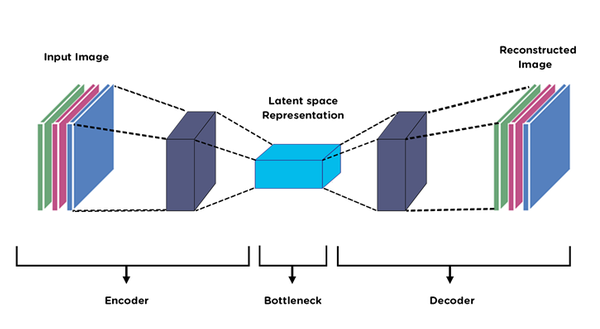

#### Adding noise to the images - Gaussian Noise

In [ ]:
# Setting the device variable to cuda if abailable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch

# Noise introduction function
# Receives as parameters the image (or batch of images) and a standard deviation
# value (stddev). The larger the stddev, the noisier the image.

def add_noise(x, stddev=0.2):
    # Set random noise with the stddev of interest
    noise = torch.randn(x.size()) * stddev
    # Allocate data to the device in use
    if x.is_cuda:
        noise = noise.to(device)
    # Introduce noise to the data
    noisy_x = x + noise
    # Clamps the results, preventing values that are out of the [0,1] range
    # For documentation:
    # https://pytorch.org/docs/stable/generated/torch.clamp.html
    return torch.clamp(noisy_x, 0, 1)

Visualizing original samples and samples with Gaussian noise

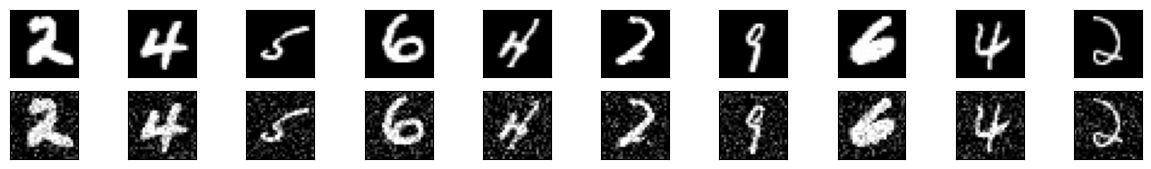

In [ ]:
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
imgs, _ = next(dataiter)
noisy_imgs = add_noise(imgs)

n = 10
plt.figure(figsize=(15, 3))
for i in range(n):

    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(imgs[i].squeeze().numpy(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_imgs[i].squeeze().numpy(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## **Task 1:** (3 pts) Can you build a denoising Autoencoder?

#### Build a Denoising Autoencoder, following the configuration and parameters described in the instructions and image below

1. Implement a method for encoding, that takes an input image and generates a Vector of 128 dimensions,
2. Implement a method for decoding, that takes a vector of 128 dimensions and outputs an image,
3. The method `forward` will call the encoding and decoding methods.


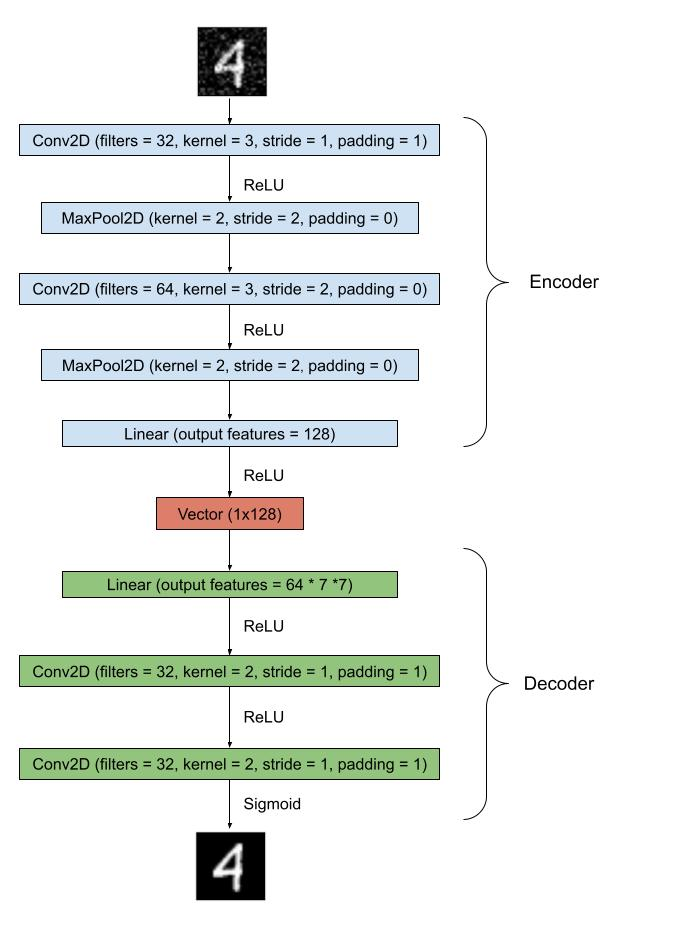


**Tip:** Be careful with dimensionality

When transitioning between convolutional and linear operations, it's essential to adapt the input of each layer accordingly.

Below, you can see an example on how to make this adjustment.

In [ ]:
# Changing the organization of a tensor

dataiter = iter(test_loader)
imgs, _ = next(dataiter)

# Lets se the shape of 1 image
img = imgs[1]
print("Image shape:", img.shape, '\n')

# for flattening (to allow use linear layers) we need to change the dimension to a vector
vector = img.view(img.size(0), -1)
print("Vector shape:", vector.shape)
print("We can observe that the image 28x28 was transformed to a vector of 28*28 = 784", '\n')

# for the inverse
img = vector.view(vector.size(0), 28, 28)
print("Image shape:", img.shape, '\n')

Image shape: torch.Size([1, 28, 28]) 

Vector shape: torch.Size([1, 784])
We can observe that the image 28x28 was transformed to a vector of 28*28 = 784 

Image shape: torch.Size([1, 28, 28]) 



### Autoencoder implementation

Bellow, the proposed neural network architecture is implemented.

In [ ]:
from torch.nn.modules.activation import Sigmoid
import torch.nn as nn

# The Autoencoder classs inherits the characteristics of the nn.module
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder implementation
        self.encoder = nn.Sequential(
            # Convolutional layer with one channel input, 32 filters with 3x3
            # dimension, stride of size 1 and 1 dimension padding
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            # ReLU activation function
            nn.ReLU(),

            # Pooling layer that gets the maximum value of a 2x2 space. No
            # padding was added and stride step of 2 was used.
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            # Convolutional layer with 32 channels input, 64 filters with 3x3
            # dimension, stride of size 1 and 1 dimension padding
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),

            # ReLU activation function
            nn.ReLU(),

            # Another pooling layer that gets the maximum value of a 2x2 space.
            # No padding was added and stride step of 2 was used.
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )

        # The following method prepares the data for a complete linear layer
        # using the flatten function
        self.linear_encoder = nn.Sequential(
            # Flattening the data to a row tensor.
            nn.Flatten(start_dim=1),

            # Complete linear layer receives all pixles from the 64 channels
            # (each 7x7) resulted from the encoder procedure
            nn.Linear(7*7*64, 128),

            # ReLU activation function
            nn.ReLU()
        )

        # On the other hande, the following method prepares the data for the
        # deconding procedure, returning the flatenned data to the "image"
        # format (channels and image size) after a segund complete layer step
        self.linear_decoder = nn.Sequential(
            # Complete linear layer receives the flattened data and returns
            # the appropiate size for unflattening in the proposed architecture
            nn.Linear(128, 7*7*64),

            # ReLu activation function
            nn.ReLU(),

            # Unflattening the data to its original dimension before the
            # flattening procedure
            nn.Unflatten(dim=1,unflattened_size=(64, 7, 7))
        )

        # Decoder implementation
        self.decoder = nn.Sequential(
            # Transpose convolutional layer that receives 64 channels and
            # returns 32 channels (32 filters) using a filter size of 2x2
            # and a stride step of 2. No padding was used.
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2),

            # ReLu activation function
            nn.ReLU(),

            # Transpose convolutional layer that receives 32 channels and
            # returns 1 channel (1 filter) using a filter size of 2x2
            # and a stride step of 2. No padding was used. This is the final
            # output of the procedure and hence it is composed of a single image
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=2, stride=2),

            # Sigmoid activation function retrieves the values on the intended
            # interval [0,1] for each pixel.
            nn.Sigmoid()
        )

    # Foward step implementation
    def forward(self, x):
        # Encoding the data
        x = self.encoder(x)
        # Flattening and applying a complete linear layer
        x = self.linear_encoder(x)
        # Applying a complete linear layer and unflattening
        x = self.linear_decoder(x)
        # Decoding the data
        x = self.decoder(x)
        return x

In [ ]:
autoencoder = Autoencoder().to(device)

# 3. Training

## **Task 2:** (3 pts) Training the Autoencoder

Use the BCE Loss and the Adam optimizer with an initial learning rate of 0.0005

In [ ]:
import gc

# Loss function with the proposed parameters
criterion = torch.nn.BCELoss()

# Adam optimizer instanciation
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=5e-4)

# 40 epochs
num_epochs = 40

As we know, training deep learning models is a memory intensive task, and the resources on the colab are limited. Hence, some ideas presented on the medium article bellow were used to manage memory on the task 2.

https://medium.com/@soumensardarintmain/manage-cuda-cores-ultimate-memory-management-strategy-with-pytorch-2bed30cab1


In [ ]:
# List to store the loss value in each iterarion
losses = []

# Epoch loop
for epoch in range(num_epochs):

    print(f'{epoch} ', end='')

    # Batch loop
    for(image_batch, _) in train_loader:
        # Allocate image batch to the device in use
        image_batch = image_batch.to(device)
        # Add noise to the images
        noisy_batch = add_noise(image_batch)
        # Apply the autoencoder
        reconstructed = autoencoder(noisy_batch)

        # Obtain step loss (the loss is computed between the original image) and
        # The output of the autoencoder
        loss = criterion(reconstructed, image_batch)

        # Optimizing and backpropagation procedure
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Include obtained loss to the loss list
        losses.append(loss)

        # Delete variables, clean cuda cache and use garbage collector for
        # memory optimization
        del image_batch
        del noisy_batch
        del reconstructed
        del loss
        torch.cuda.empty_cache()
        gc.collect()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 

In [ ]:
# Save the trained autoencoder parameters
torch.save(autoencoder.state_dict(), 'autoencoder.pt')

In [ ]:
# Turn the tensor to a list
losses_val = [l.item() for l in losses]

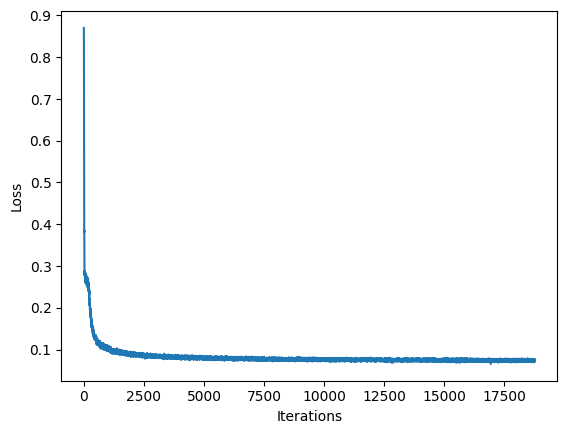

In [ ]:
# plot the loss by iteration in the training process

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(losses_val)

It is evident that 40 epochs were not necessary for this learning procedure, as the curve flattened close to 3000 iterations and more than 18000 were performed. 10 epochs would be more than enough for the task in question.

## **Task 2.1**: (0.5 pt) Name another loss function that could be used for training. Which images do we use for calculating the loss?

Answer:

Annother loss function that could be used for training is the mean squared error (MSE).

The images used to calculate the loss are the reconstructed images (output of the autoencoder) and the original image, before the noise introduction procedure. This is the correct approach because we want the autoencoder to learn to produce the original image (without noise) and not the noisy image. Hence, to achieve this goal, we need to penalize the autoencoder when its output diverges from the original image, the one that we want to obtain.

# 4. Visualizing the results

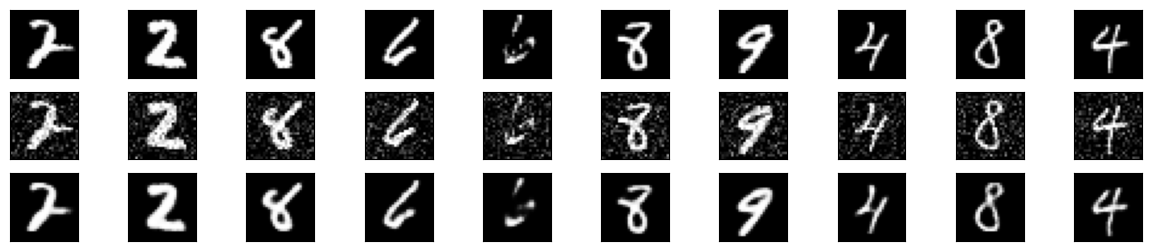

In [ ]:
dataiter = iter(test_loader)
imgs, _ = next(dataiter)
imgs = imgs.cuda()
noisy_imgs = add_noise(imgs)



# Denoise the noisy images
denoised_imgs = autoencoder(noisy_imgs)

imgs = imgs.to(torch.device('cpu'))
noisy_imgs = noisy_imgs.to(torch.device('cpu'))
denoised_imgs = denoised_imgs.to(torch.device('cpu'))

# Visualize original, noisy, and denoised images
n = 10
plt.figure(figsize=(15, 3))
for i in range(n):

    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(imgs[i].squeeze().numpy(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_imgs[i].squeeze().numpy(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Denoised images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(denoised_imgs[i].detach().squeeze().numpy(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Considering the images obtained after the reconstruction task, it is possible to say that the autoencoder learned to denoise images with moderate values of noise. Some images were reconstructed almost to its perfect original state, which is evidence that the model was succesfull in learning the denoising pattern.

In [ ]:
# Applying garbage collcting so we can save up memory

del autoencoder

torch.cuda.empty_cache()
gc.collect()

39464

# 5. Experimenting with different noise levels.

## **Task 3:** (3 pts): run an experiment, training 5 denoising autoencoders

Each model will be trained with images using different noise levels, parametrized by the following standard deviation values: 0.1, 0.2, 0.3, 0.4 and 0.5. Use 25 epochs for training.

After training:
1. On a single plot, show the curves of the loss functions evaluated on the training set for the 5 models.
2. Compare the 5 models, by:
  1. evaluating the average loss function value on the test set,
  2. showing images reconstructed by the 5 models

## Task 3 development

First, let's train five autoencoders with the proposed standard deviation values for the noise. The autoencoder training procedure is very memory expensive, hence, for this task, the notebook was restarted to free resourses. Bellow, we present all the functions and libraries used in this task.

In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import pandas as pd

batch_size = 128 # defining the batch_size

# Tensor transformation method to turn images from MNIST to tensors
tensor_transform = transforms.ToTensor()


# Setting the training dataset
train_dataset = datasets.MNIST(root='./mnist_data',
                               train=True,
                               download=True,
                               transform=tensor_transform)

# Setting the testing dataset
test_dataset = datasets.MNIST(root='./mnist_data',
                               train=False,
                               download=True,
                               transform=tensor_transform)

# Setting the training and testing datasets as pytorch dataloaders with batch
# size of 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [2]:
# Setting the device variable to cuda if abailable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Noise introduction function
# Receives as parameters the image (or batch of images) and a standard deviation
# value (stddev). The larger the stddev, the noisier the image.

def add_noise(x, stddev=0.2):
    # Set random noise with the stddev of interest
    noise = torch.randn(x.size()) * stddev
    # Allocate data to the device in use
    if x.is_cuda:
        noise = noise.to(device)
    # Introduce noise to the data
    noisy_x = x + noise
    # Clamps the results, preventing values that are out of the [0,1] range
    # For documentation:
    # https://pytorch.org/docs/stable/generated/torch.clamp.html
    return torch.clamp(noisy_x, 0, 1)

In [4]:
criterion = torch.nn.BCELoss()

num_epochs = 25

In [5]:
# The training function bellow uses the same implementation as the training
# procedure made in task 2.

# The function receives an autoencoder "ae", the noise standar deviation
# noise_std, the number of epochs num_epochs and the train loader
def ae_training_func(ae, noise_std, num_epochs, train_loader):

    losses = []

    for epoch in range(num_epochs):
        print(f'{epoch} ', end='')

        for(image_batch, _) in train_loader:
            image_batch = image_batch.to(device)
            noisy_batch = add_noise(image_batch, noise_std)
            reconstructed = ae(noisy_batch)

            loss = criterion(reconstructed, image_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss)

    return losses

In [6]:
from torch.nn.modules.activation import Sigmoid
import torch.nn as nn

# The Autoencoder classs inherits the characteristics of the nn.module
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder implementation
        self.encoder = nn.Sequential(
            # Convolutional layer with one channel input, 32 filters with 3x3
            # dimension, stride of size 1 and 1 dimension padding
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            # ReLU activation function
            nn.ReLU(),

            # Pooling layer that gets the maximum value of a 2x2 space. No
            # padding was added and stride step of 2 was used.
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            # Convolutional layer with 32 channels input, 64 filters with 3x3
            # dimension, stride of size 1 and 1 dimension padding
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),

            # ReLU activation function
            nn.ReLU(),

            # Another pooling layer that gets the maximum value of a 2x2 space.
            # No padding was added and stride step of 2 was used.
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )

        # The following method prepares the data for a complete linear layer
        # using the flatten function
        self.linear_encoder = nn.Sequential(
            # Flattening the data to a row tensor.
            nn.Flatten(start_dim=1),

            # Complete linear layer receives all pixles from the 64 channels
            # (each 7x7) resulted from the encoder procedure
            nn.Linear(7*7*64, 128),

            # ReLU activation function
            nn.ReLU()
        )

        # On the other hande, the following method prepares the data for the
        # deconding procedure, returning the flatenned data to the "image"
        # format (channels and image size) after a segund complete layer step
        self.linear_decoder = nn.Sequential(
            # Complete linear layer receives the flattened data and returns
            # the appropiate size for unflattening in the proposed architecture
            nn.Linear(128, 7*7*64),

            # ReLu activation function
            nn.ReLU(),

            # Unflattening the data to its original dimension before the
            # flattening procedure
            nn.Unflatten(dim=1,unflattened_size=(64, 7, 7))
        )

        # Decoder implementation
        self.decoder = nn.Sequential(
            # Transpose convolutional layer that receives 64 channels and
            # returns 32 channels (32 filters) using a filter size of 2x2
            # and a stride step of 2. No padding was used.
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2),

            # ReLu activation function
            nn.ReLU(),

            # Transpose convolutional layer that receives 32 channels and
            # returns 1 channel (1 filter) using a filter size of 2x2
            # and a stride step of 2. No padding was used. This is the final
            # output of the procedure and hence it is composed of a single image
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=2, stride=2),

            # Sigmoid activation function retrieves the values on the intended
            # interval [0,1] for each pixel.
            nn.Sigmoid()
        )

    # Foward step implementation
    def forward(self, x):
        # Encoding the data
        x = self.encoder(x)
        # Flattening and applying a complete linear layer
        x = self.linear_encoder(x)
        # Applying a complete linear layer and unflattening
        x = self.linear_decoder(x)
        # Decoding the data
        x = self.decoder(x)
        return x

<br>
<br>
<br>
<br>
<br>
<br>

All trained autoencoders were saved in ".pt" files so we could retrieve its parameters (state_dict) for the evaluation task. Again, the training procedure is memory intensive and saving the results in a file guarantees that we do not lose the trained final models. Each model was trained in 25 epochs, with the Adam optimizer and BCELoss. For each trained model we printed the state dictionary and the loss values in each iteration. The loss values were also saved in csv files so we could use it in the evaluation step.

In [9]:
# Autoencoder 1
autoencoder1 = Autoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder1.parameters(), lr=5e-4)

losses1 = ae_training_func(autoencoder1, .1, num_epochs, train_loader)

torch.save(autoencoder1.state_dict(), 'autoencoder1.pt')

print(autoencoder1.state_dict())
print(losses1)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 OrderedDict([('encoder.0.weight', tensor([[[[-0.3147,  0.1779, -0.1451],
          [ 0.2418, -0.0903, -0.0568],
          [ 0.2753,  0.1425, -0.2017]]],


        [[[ 0.0094,  0.0499, -0.1488],
          [-0.1880, -0.2398, -0.1337],
          [ 0.1794, -0.2430, -0.2273]]],


        [[[ 0.3724,  0.0212, -0.1515],
          [-0.0674, -0.0606,  0.3823],
          [-0.3435, -0.4113,  0.0770]]],


        [[[ 0.0593, -0.5855, -0.3588],
          [ 0.3541,  0.2165, -0.2001],
          [-0.1223,  0.2695,  0.2859]]],


        [[[ 0.4162,  0.5166,  0.3957],
          [ 0.3742,  0.0420, -0.3957],
          [-0.3459, -0.1618, -0.2156]]],


        [[[-0.1331,  0.3729,  0.5189],
          [ 0.1510,  0.0868, -0.0206],
          [ 0.2038, -0.1075,  0.3047]]],


        [[[-0.2337,  0.2005,  0.0011],
          [ 0.2807, -0.1868, -0.1367],
          [ 0.2311,  0.2272, -0.4704]]],


        [[[ 0.2186,  0.5022,  0.2554],
          [ 0.0

In [14]:
losses_val1 = [l.item() for l in losses1]
print(losses_val1)

import pandas as pd

pd.Series(losses_val1).to_csv('losses1')

[0.6793345212936401, 0.6766762137413025, 0.6729147434234619, 0.6668481230735779, 0.6587898135185242, 0.6480436325073242, 0.6347860097885132, 0.6177434921264648, 0.5971174240112305, 0.5716109871864319, 0.542604386806488, 0.5122988224029541, 0.4768473207950592, 0.44901561737060547, 0.4092612564563751, 0.40183085203170776, 0.3769185543060303, 0.3564910292625427, 0.35589706897735596, 0.3607533872127533, 0.33826273679733276, 0.36025041341781616, 0.33867594599723816, 0.32375866174697876, 0.30849745869636536, 0.29394760727882385, 0.29413074254989624, 0.28692057728767395, 0.28659459948539734, 0.28540027141571045, 0.2811293303966522, 0.2870173156261444, 0.2763284742832184, 0.2833448052406311, 0.28144359588623047, 0.28165823221206665, 0.27492204308509827, 0.27802178263664246, 0.2763487994670868, 0.27139437198638916, 0.267474502325058, 0.2727300822734833, 0.2704695463180542, 0.2654074728488922, 0.276458740234375, 0.26398783922195435, 0.2700081765651703, 0.2667240798473358, 0.26284852623939514, 0.

In [10]:
# Autoencoder 2
autoencoder2 = Autoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder2.parameters(), lr=5e-4)

losses2 = ae_training_func(autoencoder2, .2, num_epochs, train_loader)

torch.save(autoencoder2.state_dict(), 'autoencoder2.pt')
print(autoencoder2.state_dict())
losses_val2 = [l.item() for l in losses2]
print(losses_val2)
pd.Series(losses_val2).to_csv('losses2')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 OrderedDict([('encoder.0.weight', tensor([[[[ 8.3690e-02, -6.4928e-03,  1.0369e-01],
          [ 3.6350e-01, -8.4769e-02, -1.1574e-01],
          [-4.2450e-02,  3.9583e-01,  3.7927e-01]]],


        [[[ 1.8292e-01,  6.8350e-01,  3.0033e-01],
          [-5.8694e-01,  1.4756e-01,  3.1974e-01],
          [-3.4975e-01, -1.2665e-01,  2.9325e-02]]],


        [[[-3.5193e-01,  2.4581e-01,  3.3897e-01],
          [-5.5752e-01, -4.4191e-03,  1.7977e-01],
          [-3.0338e-01,  2.7178e-01, -2.4542e-01]]],


        [[[ 2.3190e-02, -3.4246e-01,  2.7909e-01],
          [-7.4134e-02, -3.5769e-01,  3.5801e-01],
          [-5.6797e-02, -1.9888e-01,  2.8283e-01]]],


        [[[-2.9025e-02,  2.4485e-01, -2.5577e-01],
          [ 2.1181e-01, -4.9628e-01, -9.8537e-02],
          [ 1.6283e-01, -2.1835e-01,  9.5056e-02]]],


        [[[ 2.0251e-01,  9.1024e-04, -1.3863e-01],
          [-3.1180e-01, -1.6975e-01, -1.2484e-01],
          [-2.

In [10]:
# Autoencoder 3
autoencoder3 = Autoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder3.parameters(), lr=5e-4)

losses3 = ae_training_func(autoencoder3, .3, num_epochs, train_loader)

print(autoencoder3.state_dict())

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 OrderedDict([('encoder.0.weight', tensor([[[[-0.0030,  0.0173, -0.0401],
          [ 0.0193, -0.0903,  0.8094],
          [-0.0062, -0.0201, -0.0047]]],


        [[[ 0.2302, -0.4308, -0.5604],
          [ 0.4387, -0.2660, -0.3528],
          [ 0.4367,  0.4323,  0.2098]]],


        [[[-0.7905,  0.0158,  0.0739],
          [-0.0804, -0.0093, -0.0253],
          [-0.0324,  0.2305,  0.1156]]],


        [[[-0.2852, -0.1416, -0.2647],
          [ 0.0065, -0.1246,  0.1185],
          [-0.0357, -0.3006, -0.2363]]],


        [[[-0.0204, -1.2154, -0.2010],
          [ 0.0846,  0.1620,  0.0032],
          [-0.0402,  0.1341,  0.1261]]],


        [[[ 0.1069,  0.0704,  0.1251],
          [-1.3505,  0.1412,  0.1225],
          [ 0.0780,  0.0089,  0.1203]]],


        [[[-0.1517, -0.0455, -0.1953],
          [ 0.0410,  0.4983,  0.2779],
          [ 0.2546, -0.1951, -0.1041]]],


        [[[ 0.6379,  0.3735, -0.0917],
          [ 0.4

In [13]:
torch.save(autoencoder3.state_dict(), 'autoencoder3.pt')
losses_val3 = [l.item() for l in losses3]
print(losses_val3)
pd.Series(losses_val3).to_csv('losses3')

[0.858210563659668, 0.8534858822822571, 0.8456699252128601, 0.8355813026428223, 0.8266383409500122, 0.8117877840995789, 0.7902022004127502, 0.7678177356719971, 0.73689204454422, 0.7058196663856506, 0.6704501509666443, 0.634011447429657, 0.5965589880943298, 0.5659434199333191, 0.5380722284317017, 0.5167074203491211, 0.4908152222633362, 0.46275877952575684, 0.4130777418613434, 0.4145139455795288, 0.3960411548614502, 0.3605741262435913, 0.3571755886077881, 0.3356168270111084, 0.34666380286216736, 0.3394249975681305, 0.3254949152469635, 0.31150195002555847, 0.3032737672328949, 0.2994626462459564, 0.287089467048645, 0.3029768466949463, 0.28675132989883423, 0.2853654623031616, 0.2891601622104645, 0.2795454263687134, 0.29404935240745544, 0.29096704721450806, 0.2825812101364136, 0.2816826403141022, 0.2784183919429779, 0.28623777627944946, 0.2705553472042084, 0.2840905785560608, 0.2790766954421997, 0.27522891759872437, 0.2848288416862488, 0.2763305902481079, 0.2685408890247345, 0.26768431067466

In [14]:
# Autoencoder 4
autoencoder4 = Autoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder4.parameters(), lr=5e-4)

losses4 = ae_training_func(autoencoder4, .4, num_epochs, train_loader)

torch.save(autoencoder4.state_dict(), 'autoencoder4.pt')
print(autoencoder4.state_dict())

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 OrderedDict([('encoder.0.weight', tensor([[[[-2.1273e-01,  1.4875e-01,  1.8764e-01],
          [-5.0757e-01,  1.5127e-02,  2.4948e-01],
          [-5.9395e-01, -1.7100e-02,  2.1160e-01]]],


        [[[ 1.7723e-01, -1.9740e-01, -4.4898e-01],
          [ 2.8179e-01, -2.2905e-01, -3.0240e-01],
          [ 2.4748e-01,  8.7575e-02, -1.0906e-01]]],


        [[[-1.7618e-02,  1.7126e-01,  1.4824e-01],
          [ 1.3243e-01,  1.9323e-01, -4.2200e-02],
          [-1.7982e-02,  9.4132e-02, -4.7859e-01]]],


        [[[ 2.5916e-01,  1.9630e-01, -3.0716e-02],
          [ 3.6664e-01,  2.5731e-01,  1.2403e-01],
          [-3.0215e-01,  1.4054e-01,  2.5009e-01]]],


        [[[ 1.4831e-01,  3.1543e-01,  1.3888e-01],
          [-1.5253e-01, -3.2469e-01, -9.7332e-02],
          [ 2.5019e-01,  3.0563e-01,  1.3924e-01]]],


        [[[ 6.9886e-02,  4.9577e-02,  2.6547e-01],
          [ 1.1200e-01,  2.8104e-01,  2.1998e-01],
          [-3.

In [15]:
losses_val4 = [l.item() for l in losses4]
print(losses_val4)
pd.Series(losses_val4).to_csv('losses4')

[0.6726388335227966, 0.6700174808502197, 0.6659574508666992, 0.6606423258781433, 0.6509827375411987, 0.6384882926940918, 0.6216609477996826, 0.6007317304611206, 0.572355329990387, 0.5390795469284058, 0.506393551826477, 0.47960180044174194, 0.4441995322704315, 0.4092567563056946, 0.3888702690601349, 0.3839379847049713, 0.37804582715034485, 0.35874098539352417, 0.3359479308128357, 0.3507257103919983, 0.32430940866470337, 0.31096509099006653, 0.3014305531978607, 0.30874213576316833, 0.29997915029525757, 0.2975374460220337, 0.29288679361343384, 0.27552181482315063, 0.2891427278518677, 0.2818041443824768, 0.28192415833473206, 0.277128666639328, 0.27848610281944275, 0.28029799461364746, 0.27657708525657654, 0.2778865098953247, 0.27471470832824707, 0.2716907858848572, 0.2715449929237366, 0.26999565958976746, 0.26578405499458313, 0.2689070403575897, 0.27728384733200073, 0.27266350388526917, 0.2760513126850128, 0.26491251587867737, 0.26719287037849426, 0.2666078209877014, 0.257697731256485, 0.2

In [7]:
# Autoencoder 5
autoencoder5 = Autoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder5.parameters(), lr=5e-4)

losses5 = ae_training_func(autoencoder5, .5, num_epochs, train_loader)

torch.save(autoencoder5.state_dict(), 'autoencoder5.pt')
print(autoencoder5.state_dict())

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 OrderedDict([('encoder.0.weight', tensor([[[[ 2.7788e-02, -2.0924e-01,  2.0044e-01],
          [-8.1713e-02,  3.5559e-01,  2.8656e-01],
          [ 2.4822e-03,  2.3949e-01,  1.7458e-01]]],


        [[[ 8.5780e-02,  2.8382e-01, -6.9882e-01],
          [-3.9094e-02,  4.1015e-01,  3.4214e-01],
          [-3.0589e-01,  1.1204e-01, -7.4979e-02]]],


        [[[ 1.4538e-01,  3.1972e-01,  1.3132e-01],
          [ 2.1417e-01,  2.6447e-01,  1.5787e-01],
          [ 8.2609e-02, -1.8024e-01, -1.3021e-02]]],


        [[[ 3.2513e-01,  2.5334e-01,  2.1407e-01],
          [ 2.7202e-01,  1.9510e-01, -1.3557e-01],
          [ 1.7785e-01,  7.1424e-02, -4.8564e-02]]],


        [[[ 5.7360e-02, -2.5623e-02, -8.3925e-02],
          [ 1.1253e-01,  2.8493e-03, -1.5329e+00],
          [ 9.3734e-02, -1.4611e-01, -6.2084e-02]]],


        [[[ 4.5286e-01, -4.2631e-01,  4.9441e-02],
          [ 3.3351e-01,  4.9373e-01,  1.0790e-01],
          [-1.

In [8]:
losses_val5 = [l.item() for l in losses5]
print(losses_val5)
pd.Series(losses_val5).to_csv('losses5')

[0.5947443246841431, 0.5905899405479431, 0.5894925594329834, 0.5875886082649231, 0.5855258107185364, 0.5792215466499329, 0.5740375518798828, 0.5632553100585938, 0.5517446398735046, 0.5349120497703552, 0.5147037506103516, 0.4934324324131012, 0.46576106548309326, 0.43759459257125854, 0.4193471074104309, 0.39344677329063416, 0.37849491834640503, 0.3844185471534729, 0.3561631441116333, 0.3502744734287262, 0.33487534523010254, 0.3294539749622345, 0.3145207166671753, 0.3081505298614502, 0.29607078433036804, 0.2924886643886566, 0.2990381419658661, 0.2918393015861511, 0.283194899559021, 0.2771672308444977, 0.2849758565425873, 0.2819986045360565, 0.2748429477214813, 0.2740149199962616, 0.2745121419429779, 0.2773131728172302, 0.27784162759780884, 0.27464765310287476, 0.27183958888053894, 0.26828911900520325, 0.2774481475353241, 0.27404165267944336, 0.2605751156806946, 0.27195408940315247, 0.2720048129558563, 0.2771075963973999, 0.2663395404815674, 0.26623469591140747, 0.2774522006511688, 0.26405

<br>
<br>
<br>

# Models evaluation

As previously stated, due to memory consumption, all five models were saved as ".pt" files. The trained models state dictionary can be seen printed in each autoencoder cell as well as the loss by training iteration list. In this section, the trained models were loaded from the computer HD and will be used for the evaluation procedures.

Firstly, lets us evaluate the loss curve for the training procedure to see if there is a diferrence on its behavior deppending on the noise value.

The trained autoencoders are

* Autoencoder 1: trained using noisy images with stddev = 0.1
* Autoencoder 2: trained using noisy images with stddev = 0.2
* Autoencoder 3: trained using noisy images with stddev = 0.3
* Autoencoder 4: trained using noisy images with stddev = 0.4
* Autoencoder 5: trained using noisy images with stddev = 0.5

In [10]:
import pandas as pd
import torch
from torchvision import datasets
from torchvision import transforms
import pandas as pd
from torch.nn.modules.activation import Sigmoid
import torch.nn as nn
import matplotlib.pyplot as plt

In [11]:
import torch
from torchvision import datasets
from torchvision import transforms
import pandas as pd

batch_size = 128 # defining the batch_size

# Tensor transformation method to turn images from MNIST to tensors
tensor_transform = transforms.ToTensor()


# Setting the training dataset
train_dataset = datasets.MNIST(root='./mnist_data',
                               train=True,
                               download=True,
                               transform=tensor_transform)

# Setting the testing dataset
test_dataset = datasets.MNIST(root='./mnist_data',
                               train=False,
                               download=True,
                               transform=tensor_transform)

# Setting the training and testing datasets as pytorch dataloaders with batch
# size of 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [12]:
# Setting the device variable to cuda if abailable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
# Noise introduction function
# Receives as parameters the image (or batch of images) and a standard deviation
# value (stddev). The larger the stddev, the noisier the image.

def add_noise(x, stddev=0.2):
    # Set random noise with the stddev of interest
    noise = torch.randn(x.size()) * stddev
    # Allocate data to the device in use
    if x.is_cuda:
        noise = noise.to(device)
    # Introduce noise to the data
    noisy_x = x + noise
    # Clamps the results, preventing values that are out of the [0,1] range
    # For documentation:
    # https://pytorch.org/docs/stable/generated/torch.clamp.html
    return torch.clamp(noisy_x, 0, 1)

In [14]:
from torch.nn.modules.activation import Sigmoid
import torch.nn as nn

# The Autoencoder classs inherits the characteristics of the nn.module
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder implementation
        self.encoder = nn.Sequential(
            # Convolutional layer with one channel input, 32 filters with 3x3
            # dimension, stride of size 1 and 1 dimension padding
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            # ReLU activation function
            nn.ReLU(),

            # Pooling layer that gets the maximum value of a 2x2 space. No
            # padding was added and stride step of 2 was used.
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            # Convolutional layer with 32 channels input, 64 filters with 3x3
            # dimension, stride of size 1 and 1 dimension padding
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),

            # ReLU activation function
            nn.ReLU(),

            # Another pooling layer that gets the maximum value of a 2x2 space.
            # No padding was added and stride step of 2 was used.
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )

        # The following method prepares the data for a complete linear layer
        # using the flatten function
        self.linear_encoder = nn.Sequential(
            # Flattening the data to a row tensor.
            nn.Flatten(start_dim=1),

            # Complete linear layer receives all pixles from the 64 channels
            # (each 7x7) resulted from the encoder procedure
            nn.Linear(7*7*64, 128),

            # ReLU activation function
            nn.ReLU()
        )

        # On the other hande, the following method prepares the data for the
        # deconding procedure, returning the flatenned data to the "image"
        # format (channels and image size) after a segund complete layer step
        self.linear_decoder = nn.Sequential(
            # Complete linear layer receives the flattened data and returns
            # the appropiate size for unflattening in the proposed architecture
            nn.Linear(128, 7*7*64),

            # ReLu activation function
            nn.ReLU(),

            # Unflattening the data to its original dimension before the
            # flattening procedure
            nn.Unflatten(dim=1,unflattened_size=(64, 7, 7))
        )

        # Decoder implementation
        self.decoder = nn.Sequential(
            # Transpose convolutional layer that receives 64 channels and
            # returns 32 channels (32 filters) using a filter size of 2x2
            # and a stride step of 2. No padding was used.
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2),

            # ReLu activation function
            nn.ReLU(),

            # Transpose convolutional layer that receives 32 channels and
            # returns 1 channel (1 filter) using a filter size of 2x2
            # and a stride step of 2. No padding was used. This is the final
            # output of the procedure and hence it is composed of a single image
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=2, stride=2),

            # Sigmoid activation function retrieves the values on the intended
            # interval [0,1] for each pixel.
            nn.Sigmoid()
        )

    # Foward step implementation
    def forward(self, x):
        # Encoding the data
        x = self.encoder(x)
        # Flattening and applying a complete linear layer
        x = self.linear_encoder(x)
        # Applying a complete linear layer and unflattening
        x = self.linear_decoder(x)
        # Decoding the data
        x = self.decoder(x)
        return x

<br>
<br>
<br>
<br>
<br>

In this section, the training loss values by iteration were loaded and plotted on a graph for comparison:

In [49]:
losses_val1 = list(pd.read_csv('losses1')['0'])
losses_val2 = list(pd.read_csv('losses2')['0'])
losses_val3 = list(pd.read_csv('losses3')['0'])
losses_val4 = list(pd.read_csv('losses4')['0'])
losses_val5 = list(pd.read_csv('losses5')['0'])

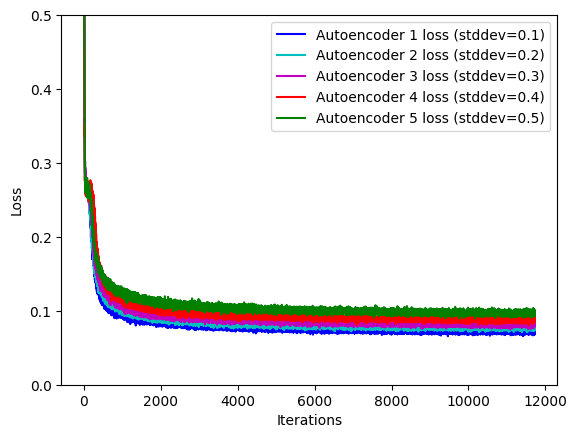

In [50]:
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(losses_val1, 'b', label='Autoencoder 1 loss (stddev=0.1)')
plt.plot(losses_val2, 'c', label='Autoencoder 2 loss (stddev=0.2)')
plt.plot(losses_val3, 'm', label='Autoencoder 3 loss (stddev=0.3)')
plt.plot(losses_val4, 'r', label='Autoencoder 4 loss (stddev=0.4)')
plt.plot(losses_val5, 'g', label='Autoencoder 5 loss (stddev=0.5)')
plt.ylim(0, 0.5)
plt.legend()

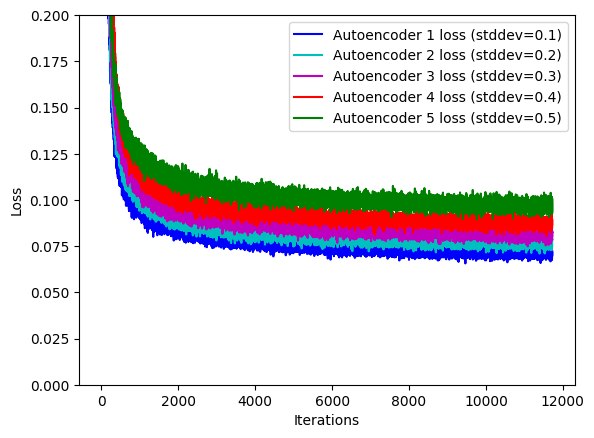

In [51]:
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(losses_val1, 'b', label='Autoencoder 1 loss (stddev=0.1)')
plt.plot(losses_val2, 'c', label='Autoencoder 2 loss (stddev=0.2)')
plt.plot(losses_val3, 'm', label='Autoencoder 3 loss (stddev=0.3)')
plt.plot(losses_val4, 'r', label='Autoencoder 4 loss (stddev=0.4)')
plt.plot(losses_val5, 'g', label='Autoencoder 5 loss (stddev=0.5)')
plt.ylim(0, 0.2)
plt.legend()

<br>
<br>
<br>
<br>
<br>
<br>

Analysing the figure, it is noticeable that the training loss curve for the autoencoders trained in noisier images (larger standard deviation) converge to lower values. For example, the training loss curve for the autoencoder trained with stddev of 0.1 (autoencoder 1) stabilizes around the value 0.075, and the training loss curve for the autoencoder trained with stddev of 0.5 (autoencoder 5) stabilizes around the value of 0.1. It is noticeable that the higher the noise stddev, the larger the value on which the curve converges. This is to be expected, since it is more dificult to train to denoise images that are more warped by interference. But it is necessary to note that this loss is related to the training set, and there is no guarantee that the performance of these models will maintain with novel data.

In the next section, we will analise images reconstructed by the same models using a noise stddev of 0.4 (arbitrary) on a set of MNIST images. Then, finally, we will obtain the mean loss for each model in the test set.

Firstly, let us load the trained models:

<br>
<br>
<br>

In [19]:
state_dict1 = torch.load('autoencoder1.pt')
autoencoder1 = Autoencoder().to(device)
autoencoder1.load_state_dict(state_dict1)

<All keys matched successfully>

In [20]:
state_dict2 = torch.load('autoencoder2.pt')
autoencoder2 = Autoencoder().to(device)
autoencoder2.load_state_dict(state_dict2)

<All keys matched successfully>

In [21]:
state_dict3 = torch.load('autoencoder3.pt')
autoencoder3 = Autoencoder().to(device)
autoencoder3.load_state_dict(state_dict3)

<All keys matched successfully>

In [22]:
state_dict4 = torch.load('autoencoder4.pt')
autoencoder4 = Autoencoder().to(device)
autoencoder4.load_state_dict(state_dict4)

<All keys matched successfully>

In [23]:
state_dict5 = torch.load('autoencoder5.pt')
autoencoder5 = Autoencoder().to(device)
autoencoder5.load_state_dict(state_dict5)

<All keys matched successfully>

In [68]:
dataiter = iter(test_loader)
imgs, _ = next(dataiter)
imgs = imgs.cuda()
noisy_imgs = add_noise(imgs, 0.4)

<br>
<br>
<br>
<br>

Now, let us use some noisy images and compare how each model reconstructs them to the original one.

In [69]:
def plot_func(autoencoder, imgs, noisy_imgs):
  # Denoise the noisy images
  denoised_imgs = autoencoder(noisy_imgs)

  imgs = imgs.to(torch.device('cpu'))
  noisy_imgs = noisy_imgs.to(torch.device('cpu'))
  denoised_imgs = denoised_imgs.to(torch.device('cpu'))

  # Visualize original, noisy, and denoised images
  n = 10
  plt.figure(figsize=(15, 3))
  for i in range(n):

      # Original images
      ax = plt.subplot(3, n, i + 1)
      plt.imshow(imgs[i].squeeze().numpy(), cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # Noisy images
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(noisy_imgs[i].squeeze().numpy(), cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # Denoised images
      ax = plt.subplot(3, n, i + 1 + 2 * n)
      plt.imshow(denoised_imgs[i].detach().squeeze().numpy(), cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

  plt.show()

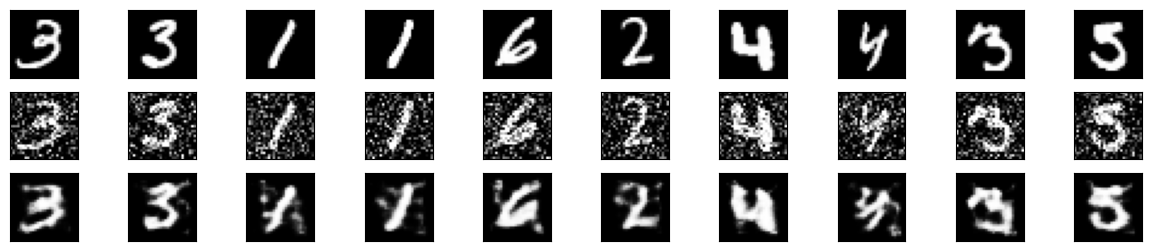

In [70]:
plot_func(autoencoder1, imgs, noisy_imgs)

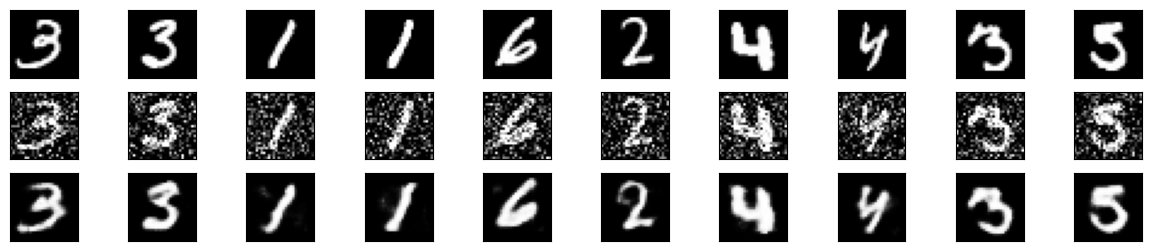

In [71]:
plot_func(autoencoder2, imgs, noisy_imgs)

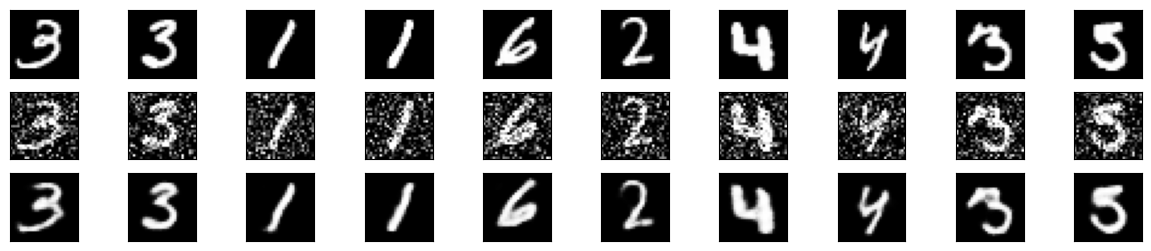

In [72]:
plot_func(autoencoder3, imgs, noisy_imgs)

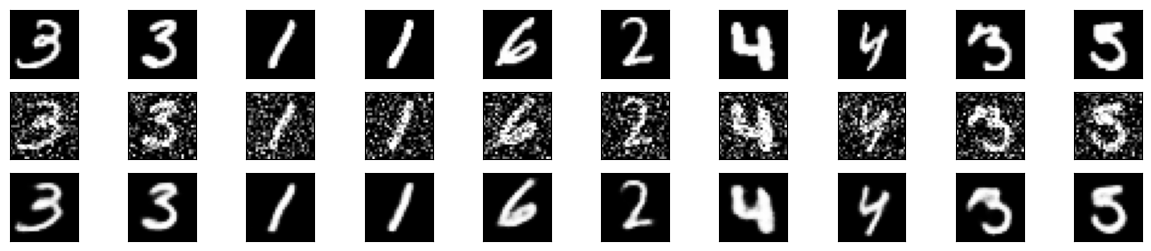

In [73]:
plot_func(autoencoder4, imgs, noisy_imgs)

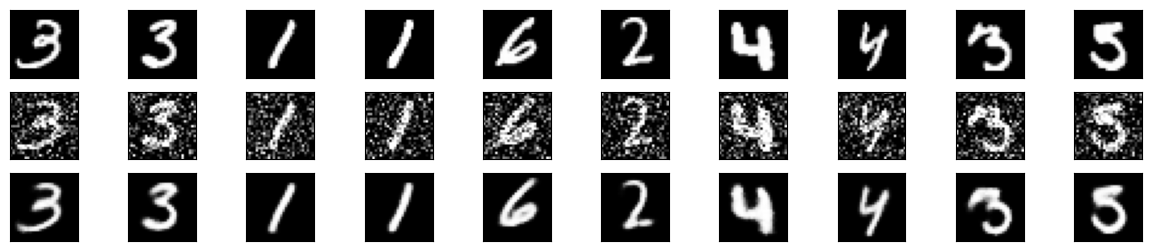

In [74]:
plot_func(autoencoder5, imgs, noisy_imgs)

<br>
<br>
<br>

It is notable that the autoencoder1 (trained with noise stddev 0.1) performs poorly in the reconstruction task and the higher the sddtev that the model was trained, the better its performance in the reconstruction procedure. This behavior is notable because it contradicts the result in the last lask, where we concluded that the training loss for autoencoders trained with lower noise sttdev converges for lower values. The models trained with noisier images were capable of learning better the denoising procedure, since they were presented to noisier images. Hence, even with lower performance considering the training loss, these models presented better results for the reconstruction task.

Let us analyse the mean test loss for each model. The function presented bellow receives an autoencoder and a test_loader. Then, for each batch, it adds noise to the images, applies the given autoencoder and calculates the loss comparing the reconstructed image to the original one and saves it on a list. Finally, it uses a counter (i) that counted the number of batches to obtain the mean.

In [75]:
def ae_testing_func(ae, test_loader):

    i = 0
    losses = []

    for(image_batch, _) in test_loader:
      image_batch = image_batch.to(device)
      noisy_batch = add_noise(image_batch, 0.8)
      reconstructed = ae(noisy_batch)

      loss = criterion(reconstructed, image_batch)

      losses.append(loss)

      losses_val = [l.item() for l in losses]

      i += 1
    mean_losses_val = sum(losses_val)/i

    return mean_losses_val

In [76]:
ae_testing_func(autoencoder1, test_loader)

0.37688710795173164

In [77]:
ae_testing_func(autoencoder2, test_loader)

0.2773585485506661

In [78]:
ae_testing_func(autoencoder3, test_loader)

0.20329894615879543

In [79]:
ae_testing_func(autoencoder4, test_loader)

0.15869984445692617

In [80]:
ae_testing_func(autoencoder5, test_loader)

0.13872926201246963

<br>
<br>
<br>

Considering the results above, we can conclude that the autoencoders that were treined using noisier images presented lower mean loss value for the test dataset. This is evidence that the models that were trained in a more challenging environment, with noisier images, were more succesful in learning the patterns of the reconstruction procedure.

<br>
<br>
<br>

## **Task 3.1**: (0.5 pt) Write your observations about the experiments

Answer:

* Training neural networks is a memory intensive task and the colab resources that are available for free can be unsufficient if memory is not well managed. For task 2, memory management techniques such as using garbage collection and keepping track of unused variables and deleting them were essential to reduce memory cost. The time to train the model was increased, even when using a TPU, but the memory cost was greatly reduced.

* The training loss curve for the autoencoder on task 2 flattened close to 3000 iterations and more than 180000 were performed considering the 40 training epochs. This is evidence that 40 epochs is way beyond the necessary for this task, and little gain on learning was obtained after 10 epochs. Hence, I would it was not necessary to use 40 epochs of training, which costed greatly in memory terms.

* The autoencoder trained on task 2 was capable of reconstructing noisy images with excellent performance, as is evident on the noisy images reconstruction example. Hence, the model was capable of learning the pattern for denoising an image with a moderate level of introduced noise.

* Task 3 was a challenge considering the availability of memory on the colab resources and the number of training epochs used to train the five models. Hence, it was a better approach to train each model and save the results for evaluation purposes later than trying to train and maintain all the information from the learning process of all models. The same methods utilized to manage memory on task 2 where used on other iterations of the experiment, but they were not enough to sustain this level of memory use. Because of this problem, the procedures were removed and each model was trained separately and saved as well as the training loss values in each iteration. This data was loaded on a clean enviroment (reseted runtime) for the evaluation tasks.

* Analysing the training loss curves, it is also notable that 25 epochs were well above the necessary for this task, consuming resources that were not needed. All curves converged on 2000 iterations and more than 10000 were performed for each model. Hence, 5 to 10 epochs would be more than enough for the given task.

* The most intereting result to take note is that the models trained with lower noise stddev presented lower values of convergence for the training loss curves, but performed worst on new data (test data) and in the reconstruction task in general. This is evidence that models trained with noisier images will have more difficulty reconstructing the images, but it will learn the patterns of the denoising task with a better performence. The models trained with lower noise stddev, like autoencoder1 and autoencoder2 had way worst performance when presented with novel images than autoencoders trained with larger values of stddev for the noise.

# 6. Encoder as a feature extractor

## **Task 4:** optional/extra (1 pt) Training an external classifier

Use one of the trained models of your choice trained in task 3.

1. Use the `encoding` function to obtain a dataset of 128-dimensional features for all images of the training and testing sets. Convert those into numpy arrays.
2. Train a `LogisticRegression` classifier using the `sklearn` library using the training dataset (with 128 features obtained in step 1), see https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html for more information about this method.
3. Compute and print the accuracy score of the model for the training and testing sets.

In [ ]:
from sklearn.linear_model import LogisticRegression